# Metastable manifold in a three spin dissipative quantum east model
In this notebook we demonstrate how the general code provided in the metastability module can be used to construct the simplex of an open quantum system: in this case, that of a dissipative quantum east model defined externally. This properties and dynamics of this simplex are then briefly analysed.

First we need to import a necessary packages and source code.

In [276]:
import sys
import os
import time
import numpy as np
source_path = os.path.join("source/")
sys.path.insert(0,source_path)
import metastability
import random_linear_algebra
source_path = os.path.join("models/")
sys.path.insert(0,source_path)
import dissipative_quantum_east as dqe
from scipy import linalg
from matplotlib import pyplot
from matplotlib import cm

Next we define the model, at parameters known to exhibit metastability, with a gap between the 4th and 5th eigenmodes.

In [277]:
sites = 3
decay_rate = 1
field = 0.1
temperature = 0.0001
hardness = 0.999
model = dqe.master_operator(sites, decay_rate, field, temperature, hardness)

Now we need to diagonalize the master operator: this is done by representing the Lindbladian as a matrix, then transforming the resulting eigenvectors into their corresponding matrix representation. Combinations of the 3rd and 4th modes are then taken to construct a hermitian basis of matrices. Note the large gap between the 4th and 5th eigenvalues.

In [278]:
metastable_phases = sites + 1
extra_eigenvalues = 1
eigenvalues, left_eigenmatrices, right_eigenmatrices = model.spectrum(metastable_phases, 
                                                                      extra_eigenvalues)
print("Eigenvalues:")
print(eigenvalues)
new_left_eigenmatrix_1 = (left_eigenmatrices[2] + np.conjugate(left_eigenmatrices[2]).T)/2
new_left_eigenmatrix_2 = (left_eigenmatrices[2] - np.conjugate(left_eigenmatrices[2]).T)/2j
new_right_eigenmatrix_1 = (right_eigenmatrices[2] + right_eigenmatrices[3])
new_right_eigenmatrix_2 = (right_eigenmatrices[2] - right_eigenmatrices[3])/1j

left_eigenmatrices[2] = new_left_eigenmatrix_1
left_eigenmatrices[3] = new_left_eigenmatrix_2
right_eigenmatrices[2] = new_right_eigenmatrix_1
right_eigenmatrices[3] = new_right_eigenmatrix_2

Eigenvalues:
[ 0.00000000e+00-0.j -9.32500000e-07-0.j -2.96070000e-06-0.j
 -2.96070000e-06+0.j -2.07537518e-02-0.j]


We now simply input this hermitian basis over the low lying subspace of left eigenmatrices into the generic simplex constructing algorithm described in the paper. As a check, these are then used to construct the probability operators dual to the metastable phases, and subsequently estimate the classicality.

In [279]:
simplex_vertices = metastability.simplex_vertices(left_eigenmatrices[::-1], 
                                                  rotations = 2)
probability_operators = metastability.probability_operators(left_eigenmatrices[::-1],
                                                            simplex_vertices)
classicality = metastability.classicality(probability_operators)

print("Vertices:")
for i in range(metastable_phases):
	print(np.around(simplex_vertices[i].real, 3))
    
print("\nClassicality:")
print(classicality.real)

Vertices:
[ 0.487 -0.317 -1.149  1.   ]
[ 0.021  0.577 -1.149  1.   ]
[0.    0.    0.005 1.   ]
[-0.508 -0.26  -1.149  1.   ]

Classicality:
9.837171582495994e-07


To test this simplex visually, we can project a set of randomly generated initial states onto the coefficients of the hermitian basis of long time modes, and plot them along with the simplex. The stationary state is indicated by the red dot.

In [280]:
states = random_linear_algebra.random_complex_vector(8, 10000)
projected_states = np.einsum('ijk,lk,lj->li', left_eigenmatrices,
                             states, np.conjugate(states))

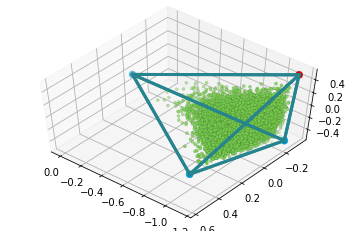

In [285]:
Virid = cm.viridis
ax = pyplot.axes(projection = '3d')
ax.scatter(projected_states.T[1].real, 
           projected_states.T[2].real, 
           projected_states.T[3].real, 
           s = 10, color = Virid(0.8), lw = 0.1, edgecolors = 'k')
for i in range(4):
	for j in range(4):
			pyplot.plot([simplex_vertices.T[2][i], simplex_vertices.T[2][j]], 
                        [simplex_vertices.T[1][i], simplex_vertices.T[1][j]], 
                        [simplex_vertices.T[0][i], simplex_vertices.T[0][j]], 
                        color = Virid(0.45), lw = 3, zorder = 50)
ax.scatter(simplex_vertices.T[2], simplex_vertices.T[1], simplex_vertices.T[0], 
           c = [(0.8,0,0,1), (0,0.6,0.8,1), (0,0.6,0.8,0.6), (0,0.6,0.8,1)],   
           lw = [0.5, 0.5, 0.3, 0.5], s = 50, depthshade = False, zorder = 500)
ax.view_init(55, 130)